In [1]:
experiment_name = '25similar'
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

Setting up variables & DB connection for experiment:

*******************
_exp3
*******************

Snorkel session connected to:  postgres:///snorkel_exp3


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
import seaborn as sns
from snorkel.annotations import save_marginals

In [3]:
from snorkel.lf_helpers import *
import pickle,glob

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
import pandas as pd
from MLutils import cohen_kappa_score, plot_marginals_histogram, neg_to_bin_labels

In [5]:
from MLutils import diversity_heatmap, merge_pickles_pred_dicts

In [6]:
# TODO move in LSTM training section

# needed to train the LSTM here
train = session.query(REGULATOR).filter(REGULATOR.split == 0).order_by(REGULATOR.id).all()
dev = session.query(REGULATOR).filter(REGULATOR.split == 1).order_by(REGULATOR.id).all()
test = session.query(REGULATOR).filter(REGULATOR.split == 2).order_by(REGULATOR.id).all()
unlab = session.query(REGULATOR).filter(REGULATOR.split == 3).order_by(REGULATOR.id).all()

In [7]:
# Determine mean sentence size per set

In [8]:
# TODO: drop v big sentences

In [9]:
# train_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,train))
# dev_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,dev))
# test_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,test))
# unlab_sentence_size =list(map(lambda x: len(x.get_parent().lemmas) ,unlab))

In [10]:
# print np.mean(train_sentence_size)
# print np.mean(dev_sentence_size)
# print np.mean(test_sentence_size)
# print np.mean(unlab_sentence_size)

In [11]:
session.query(REGULATOR).filter(REGULATOR.split == 3).count()

9167L

In [12]:
# c = train[0]
# s = c.get_parent()
# s.lemmas
# # REGULATOR.get_parent().lemmas

In [13]:
# make sure unmapped cands are gone

In [14]:
from sqlalchemy import  any_,or_,and_

In [15]:
#create list of unmapped cands to drop
to_drop = []
for k in range(4):
    query = session.query(REGULATOR).filter(and_(REGULATOR.split==k,~REGULATOR.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list
Adding 0 candidates from split=3 in to_drop list


In [38]:
# #drop unmapped cands
# query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
# print query.count()
# query.delete(synchronize_session=False)
# session.commit()

# Retrieve results and pick models

In [16]:
# results_dict = merge_pickles_pred_dicts(glob.glob('ml_predictions/*.pkl'), 
#                                         f1_threshold=0.49,
#                                         list_substr=['results_dict,','minFreq=3','_'],
#                                         best_model=True,
#                                        )

In [17]:
with open(path_base_learners+"/10models_tSNE_kmeans.pickle", 'rb') as f:
    results_dict = pickle.load(f)
print 'Loaded:\n',
results_dict.keys()

Loaded:


['results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=250',
 'results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=150',
 'results_dict,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=250',
 'results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_LogisticRegression',
 'results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_RandomForestClassifier',
 'results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=150',
 'CNN_no_trim,RuS_CNN',
 'biLSTM_biLSTM_lr=0.001',
 'results_dict,trim=5,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_LogisticRegression',
 'results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=250']

In [18]:
selected_models = results_dict.keys()
selected_models.sort()

# Load predicted labels from classifiers

In [19]:
from MLutils import diversity_matrix, reduce_results_dict

In [20]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [21]:
from snorkel.annotations import LabelAnnotator

In [22]:
# convert labels to -1,1....
for model in selected_models:
    results_dict[model]['label_unlab'] = dict(zip(results_dict[model]['label_unlab_prob+'].keys(),(np.array(results_dict[model]['label_unlab_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_val'] = dict(zip(results_dict[model]['label_val_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
#     results_dict[model]['label_train'] = dict(zip(results_dict[model]['label_train_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_test'] = dict(zip(results_dict[model]['label_test_prob+'].keys(),(np.array(results_dict[model]['label_test_prob+'].values())>=0.5)*2-1))


In [23]:
# TODO: drop unlabeled examples out of the unlabeled set (keep only those which can be mapped) 
# and check predicted class imbalance again

In [24]:
for model in selected_models:
    results_dict[model]['label_unlab'].values()

## Dataset statistics check:
## mapped vs unmapped cands in unlab set

This section indicates that Snorkels' failure to map candidates ruins the generalization on the unlabeled set.<br \>
<br \>
The results for exp3 were the following:<br \>
<br \>
Un-Mapped candidate class imbalance (predicted) :<br \>
-1    0.860072<br \>
 1    0.139928<br \>
<br \>

Mapped candidate class imbalance (predicted)<br \>
-1    0.725946<br \>
 1    0.274054<br \> 
Mapped candidate class imbalance (actual) :<br \>
-1    0.708302<br \>
 1    0.291698<br \>
 <br \>

In [27]:
# from utils import check_class_imbalance

In [28]:
# unlab_unmapped_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==3,~REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i'%(query.count(), k)
# unlab_unmapped_ids.extend(map(lambda x: x.id,query.all()))

In [29]:
# unlab_mapped_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==3,REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i'%(query.count(), k)
# unlab_mapped_ids.extend(map(lambda x: x.id,query.all()))

In [30]:
# model = selected_models[-1]

In [31]:
# preds_unmapped = list(map(lambda x: results_dict[model]['label_unlab'][x] , unlab_unmapped_ids))
# check_class_imbalance(preds_unmapped)

In [32]:
# preds_mapped = list(map(lambda x: results_dict[model]['label_unlab'][x] , unlab_mapped_ids))
# check_class_imbalance(preds_mapped)

** on test set (predicted) **

In [33]:
# test_ids = []
# query = session.query(REGULATOR).filter(and_(REGULATOR.split==2,REGULATOR.gold_labels.any()))
# print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
# test_ids.extend(map(lambda x: x.id,query.all()))

In [34]:
# preds_test = list(map(lambda x: results_dict[model]['label_test'][x] , test_ids))
# check_class_imbalance(preds_test)

## Port results into snorkel

In [35]:
# Include the results for validation data
def signal_annotator_unlab_val(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():
        try:
            yield model, results_dict[model]['label_unlab'][c.id]
            
        except:
            yield model, results_dict[model]['label_val'][c.id]


labeler = LabelAnnotator(label_generator=signal_annotator_unlab_val)

### Apply labeler / load label matrix from pickle

In [36]:
#regenerate L_unlab - Takes about 1h for 12 voters (100% coverage)

%time L_unlab = labeler.apply(split=3, parallelism=6)
L_unlab

Clearing existing...
Running UDF...
CPU times: user 1min 43s, sys: 5.22 s, total: 1min 49s
Wall time: 6min 6s


<9167x10 sparse matrix of type '<type 'numpy.int64'>'
	with 91670 stored elements in Compressed Sparse Row format>

In [48]:
from MLutils import balance_candidates, sample_from_csr, majority_vote, majority_vote_score, average_vote, error_analysis

In [38]:
# load from developer set & labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_dev = labeler.apply_existing(split=1, parallelism=6)



# # # Not possible -> I don't have the predictions of the classifiers.
# L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
# L_train = labeler.apply_existing(split=0, parallelism=6)

Clearing existing...
Running UDF...


In [39]:
# load unlabeled set labels (for exp3)
L_gold_unlab = load_gold_labels(session, annotator_name='gold', split=3)

### Check some label statistics

In [40]:
from MLutils import average_vote, majority_vote

** Majority voting **

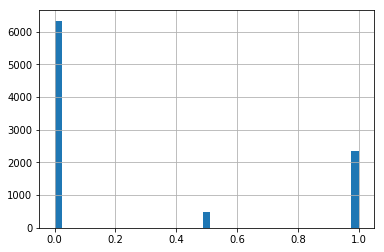

In [41]:
maj_vote_labels = majority_vote(L_unlab)
pd.Series(maj_vote_labels).hist(bins=41)

In [42]:
print "Predicted class imbalance by maj voting:"

check_class_imbalance(maj_vote_labels)

Predicted class imbalance by maj voting:


0.0    0.690848
1.0    0.256900
0.5    0.052253
dtype: float64

In [45]:
print "Majority voting:\n"
majority_vote_score(L_unlab, L_gold_unlab)

Majority voting:

pos/neg    2258:6909 24.6%/75.4%
precision  61.19
recall     63.82
f1         62.48


(0.6118895966029724, 0.6381753764393269, 0.6247561239973987)

** Average voting **

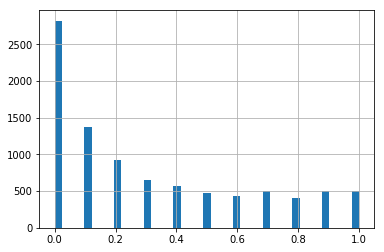

In [46]:
# get average of votes based on the preds of base classifiers
avg_vote_labels = average_vote(L_unlab)
pd.Series(avg_vote_labels).hist(bins=41)


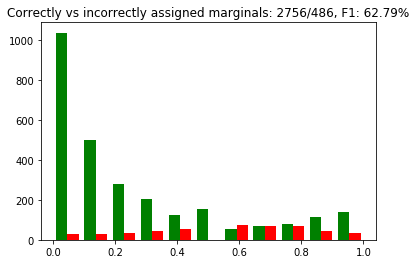

In [49]:
error_analysis(L_dev, L_gold_dev, average_voting=True)

# Denoising part

## Find dependencies between LFs


In [50]:
from itertools import combinations

In [51]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()

In [52]:
# Generate all possible dependencies with threshold from 0 to 0.15
all_deps = [ds.select(L_unlab, threshold=thresh) for thresh in np.array(range(0.1,15.1,2.5))/100.]
print list(map(lambda x: len(x) ,all_deps))
all_deps = list(np.unique(all_deps)) # delete duplicates for gridsearch
print list(map(lambda x: len(x) ,all_deps))

print "Maximum nr of dependencies: %i" %len(list(combinations(L_dev.col_index.values(),2)))

[45, 43, 42, 36, 31, 24, 22, 18]
[18, 22, 24, 31, 36, 42, 43, 45]
Maximum nr of dependencies: 45


# GM training

In [53]:
from snorkel.learning import RandomSearch, GenerativeModel, GridSearch

** Hyperparameter search **

In [54]:
param_ranges = { # parameters for the train function of the GenerativeModel
    'step_size' : [10./L_unlab.shape[0],
                  5./L_unlab.shape[0],
                   15./L_unlab.shape[0]
                  ],
    'decay' : [0.99],
    'epochs' : [50],
    'reg_param': [1e-1,1e-2,1e-3],
    'deps': all_deps
}

model_class_params = {  # parameters for the GenerativeModel
    'lf_propensity': [True]
}

searcher = RandomSearch(GenerativeModel, param_ranges,  L_unlab, model_class_params = model_class_params , n=18 )


In [55]:
%%time
gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, n_threads=6 )

Loading data...
Launching jobs...
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
[GenerativeModel] Model saved as <GenerativeModel_3>.
[GenerativeModel] Model saved as <GenerativeModel_5>.
Inferred cardinality: 2
Model 3 Done; score: 0.596324836989
Inferred cardinality: 2
Model 5 Done; score: 0.622724419335
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_1>.
[GenerativeModel] Model saved as <GenerativeModel_4>.
[GenerativeModel] Model saved as <GenerativeModel_2>.
Inferred cardinality: 2
Model 4 Done; score: 0.621468926554
Inferred cardinality: 2
Inferred cardinality: 2
Model 1 Done; score: 0.593694229625
Model 0 Done; score: 0.62555626192
[GenerativeModel] Model saved as <GenerativeModel_6>.
Inferred cardinality: 2
Model 2 Done; score: 0.375221238938
[GenerativeModel] Model saved as <GenerativeModel_7>.
Inferred cardinality: 2
Model 6

In [56]:
run_stats['#deps'] = list(map(lambda x: len(run_stats.deps[x]), run_stats.index)) # save # deps to identify 'deps'

In [57]:
run_stats

,Model,epochs,step_size,reg_param,deps,decay,Prec.,Rec.,F-1,#deps
14,15,50,0.000545,0.100,"{(4, 7, 0), (3, 9, 0), (2, 6, 0), (2, 8, 0), (...",0.99,0.593640,0.709859,0.646568,18
17,17,50,0.001636,0.100,"{(4, 7, 0), (3, 9, 0), (2, 8, 0), (4, 9, 0), (...",0.99,0.596177,0.702817,0.645120,24
11,10,50,0.001636,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (0, 5, 0), (...",0.99,0.570104,0.692958,0.625556,36
4,0,50,0.001636,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (0, 5, 0), (...",0.99,0.570104,0.692958,0.625556,36
6,6,50,0.001636,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (0, 5, 0), (...",0.99,0.561721,0.698592,0.622724,43
1,5,50,0.001636,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (0, 5, 0), (...",0.99,0.561721,0.698592,0.622724,43
2,4,50,0.001091,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (0, 5, 0), (...",0.99,0.560589,0.697183,0.621469,42
12,13,50,0.000545,0.100,"{(4, 7, 0), (3, 9, 0), (2, 8, 0), (4, 9, 0), (...",0.99,0.590102,0.654930,0.620828,24
13,12,50,0.001091,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (2, 3, 0), (...",0.99,0.586563,0.639437,0.611860,31
7,7,50,0.000545,0.100,"{(4, 7, 0), (6, 9, 0), (3, 9, 0), (2, 3, 0), (...",0.99,0.586563,0.639437,0.611860,31


In [58]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.71
Neg. class accuracy: 0.864
Precision            0.594
Recall               0.71
F1                   0.647
----------------------------------------
TP: 504 | FP: 345 | TN: 2187 | FN: 206



In [59]:
majority_vote_score(L_dev,L_gold_dev)

pos/neg    710:2532 21.9%/78.1%
precision  61.04
recall     64.65
f1         62.79


(0.6103723404255319, 0.6464788732394366, 0.627906976744186)

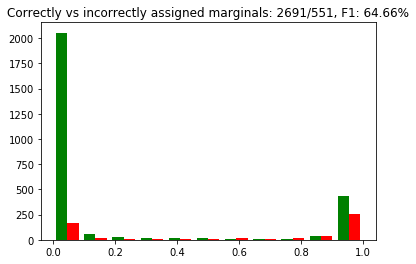

In [60]:
error_analysis(L_dev,L_gold_dev, gen_model=gen_model, )

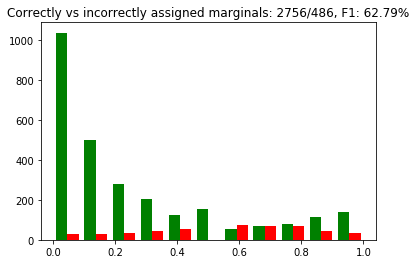

In [61]:
error_analysis(L_dev,L_gold_dev, average_voting=True )

**  (with fixed params) **

In [62]:
# %%time
# # actual training of the gen. model
# from snorkel.learning import GenerativeModel

# gen_model = GenerativeModel(lf_propensity=True, class_prior=False )

# gen_model.train(
#     L_unlab, decay=0.99, threads = 6, deps=all_deps[2], #reg_param = 1e-200, step_size = 10./L_unlab.shape[0],
#     #epochs=50
# )


In [63]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

** Load a previous model **

In [64]:
# # Possibly load previously run model
# gen_model.load('GenerativeModel_8', save_dir='checkpoints/grid_search/')


In [65]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

# Select GM and proceed

In [66]:
unlab_marginals_gen = gen_model.marginals(L_unlab)
unlab_marginals_avg = average_vote(L_unlab)
unlab_marginals_maj = majority_vote(L_unlab)


In [ ]:
# save marginals in db for training in a different file
# save_marginals(session, L_unlab, unlab_marginals)

# Discriminative model learning

In [71]:
from MLutils import balance_candidates

In [72]:
from snorkel.learning import reRNN

In [73]:
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<8221x1 sparse matrix of type '<type 'numpy.int64'>'
	with 8221 stored elements in Compressed Sparse Row format>

## Without GS

In [74]:
# plt.hist(unlab_marginals, bins=20)
# plt.title('Histogram of marginals with candidates undersampled before GM ')
# plt.show()

In [75]:
# ### balance cands here to shuffle 
# unlab_us, unlab_marginals_us = balance_candidates(unlab, unlab_marginals)


** with Generative model marginals **

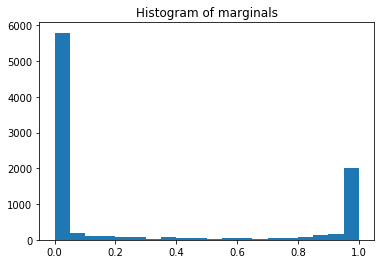

In [76]:
plot_marginals_histogram(unlab_marginals_gen, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [77]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_gen , X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5264  #epochs=20  batch size=256
[reRNN] Epoch 0 (22.01s)	Average loss=0.646344	Dev F1=41.72
[reRNN] Epoch 1 (47.44s)	Average loss=0.397521	Dev F1=43.33
[reRNN] Epoch 2 (73.31s)	Average loss=0.311475	Dev F1=37.04
[reRNN] Epoch 3 (98.79s)	Average loss=0.274011	Dev F1=41.35
[reRNN] Epoch 4 (124.99s)	Average loss=0.242708	Dev F1=46.42
[reRNN] Epoch 5 (151.32s)	Average loss=0.226415	Dev F1=40.81
[reRNN] Epoch 6 (176.60s)	Average loss=0.214447	Dev F1=49.97
[reRNN] Epoch 7 (202.17s)	Average loss=0.195886	Dev F1=51.17
[reRNN] Epoch 8 (227.31s)	Average loss=0.181078	Dev F1=51.97
[reRNN] Epoch 9 (252.41s)	Average loss=0.168464	Dev F1=50.25
[reRNN] Epoch 10 (278.26s)	Average loss=0.155555	Dev F1=53.24
[reRNN] Epoch 11 (305.84s)	Average loss=0.150571	Dev F1=52.46
[reRNN] Epoch 12 (331.66s)	Average loss=0.146984	Dev F1=55.63
[reRNN] Epoch 13 (357.28s)	Average loss=0.134662	Dev F1=53.79
[reRNN] Epoch 14 (383.06s)	Average loss=0.131648	Dev F1=54.42
[reRNN] Epoc

In [78]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.617
Neg. class accuracy: 0.826
Precision            0.498
Recall               0.617
F1                   0.551
----------------------------------------
TP: 438 | FP: 441 | TN: 2091 | FN: 272



In [79]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.585
Neg. class accuracy: 0.799
Precision            0.48
Recall               0.585
F1                   0.527
----------------------------------------
TP: 1160 | FP: 1256 | TN: 4981 | FN: 824



** with averaging marginals **

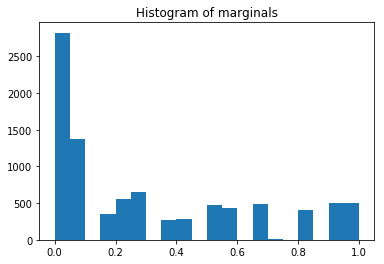

In [87]:
plot_marginals_histogram(unlab_marginals_avg, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [91]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_avg , X_dev=dev, Y_dev=L_gold_dev,  dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4710  #epochs=50  batch size=256
[reRNN] Epoch 0 (19.19s)	Average loss=0.632720	Dev F1=39.32
[reRNN] Epoch 1 (43.20s)	Average loss=0.469784	Dev F1=42.54
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (67.20s)	Average loss=0.434243	Dev F1=41.59
[reRNN] Epoch 3 (90.59s)	Average loss=0.415756	Dev F1=46.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (114.87s)	Average loss=0.407203	Dev F1=43.99
[reRNN] Epoch 5 (138.51s)	Average loss=0.397426	Dev F1=47.35
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (162.12s)	Average loss=0.390338	Dev F1=49.29
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (185.14s)	Average loss=0.385463	Dev F1=48.91
[reRNN] Epoch 8 (208.80s)	Average loss=0.378498	Dev F1=48.00
[reRNN] Epoch 9 (234.31s)	Average loss=0.376280	Dev F1=50.31
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (257.89s)	Average loss=0.375565	Dev F1=48.85
[reRNN] Epoch 11 (281.61s)	Average loss=0.369028	Dev F1=49.30
[reRNN] Epoch 12 (304.49s)	Average loss=0.3

In [92]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.644
Neg. class accuracy: 0.789
Precision            0.462
Recall               0.644
F1                   0.538
----------------------------------------
TP: 457 | FP: 533 | TN: 1999 | FN: 253



In [93]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.614
Neg. class accuracy: 0.768
Precision            0.458
Recall               0.614
F1                   0.525
----------------------------------------
TP: 1219 | FP: 1444 | TN: 4793 | FN: 765



** with majority vote labels **

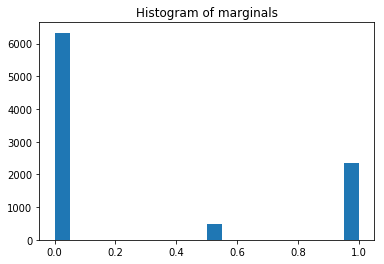

In [80]:
plot_marginals_histogram(unlab_marginals_maj, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [81]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 256
}

lstm = reRNN(seed=1701, n_threads=6,)
lstm.train(unlab, unlab_marginals_maj , X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4710  #epochs=20  batch size=256
[reRNN] Epoch 0 (19.36s)	Average loss=0.556222	Dev F1=40.55
[reRNN] Epoch 1 (42.64s)	Average loss=0.292208	Dev F1=48.40
[reRNN] Epoch 2 (66.38s)	Average loss=0.215730	Dev F1=49.50
[reRNN] Epoch 3 (89.82s)	Average loss=0.178682	Dev F1=48.07
[reRNN] Epoch 4 (113.74s)	Average loss=0.146864	Dev F1=45.96
[reRNN] Epoch 5 (137.11s)	Average loss=0.127989	Dev F1=50.00
[reRNN] Epoch 6 (160.53s)	Average loss=0.107927	Dev F1=50.35
[reRNN] Epoch 7 (183.37s)	Average loss=0.103547	Dev F1=48.19
[reRNN] Epoch 8 (207.05s)	Average loss=0.099654	Dev F1=51.55
[reRNN] Epoch 9 (230.69s)	Average loss=0.079262	Dev F1=48.65
[reRNN] Epoch 10 (253.99s)	Average loss=0.078956	Dev F1=47.20
[reRNN] Epoch 11 (277.83s)	Average loss=0.064281	Dev F1=50.32
[reRNN] Epoch 12 (300.76s)	Average loss=0.056387	Dev F1=49.94
[reRNN] Epoch 13 (323.63s)	Average loss=0.047718	Dev F1=50.07
[reRNN] Epoch 14 (346.88s)	Average loss=0.031173	Dev F1=51.49
[reRNN] Epoc

In [82]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.53
Neg. class accuracy: 0.878
Precision            0.548
Recall               0.53
F1                   0.539
----------------------------------------
TP: 376 | FP: 310 | TN: 2222 | FN: 334



In [83]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

Scores (Un-adjusted)
Pos. class accuracy: 0.486
Neg. class accuracy: 0.845
Precision            0.5
Recall               0.486
F1                   0.493
----------------------------------------
TP: 964 | FP: 965 | TN: 5272 | FN: 1020



## With GS

In [84]:
from snorkel.annotations import load_marginals
train_labels = np.array([0 if train[x].gold_labels[0].value ==-1 else 1 for x in range(len(train))]) # load train labels to mix in LSTM
unlab_marginals = load_marginals(session, split=3)


In [85]:
train_us, train_labels_us = balance_candidates(train,train_labels)

In [86]:
train_unlab_marginals = np.append(train_labels_us, unlab_marginals_us)

NameError: name 'unlab_marginals_us' is not defined

In [ ]:
plt.hist(train_unlab_marginals, bins=20)
plt.title('Histogram of marginals (candidates undersampled before GM) + GS ')
plt.show()

In [ ]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   25,
    'dropout':    0.5,
    'rebalance':  False,
    'print_freq': 1,
    'batch_size': 64
}

lstm = reRNN(seed=1701, n_threads=6)
lstm.train(train_us+unlab_us, train_unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, dev_ckpt_delay=0, **train_kwargs)


In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

# ~~~~

In [60]:
print 'Inferred performance metrics by snorkel:'
gen_model.learned_lf_stats()

Inferred performance metrics by snorkel:


,Accuracy,Coverage,Precision,Recall
0,0.971729,0.8737,0.797044,0.820487
1,0.937507,0.8369,0.629160,0.805274
2,0.925276,0.8324,0.575373,0.781947
3,0.895110,0.8037,0.492881,0.737323


## Check performance on developer set

In [63]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.968743,0.8734,0.800826,0.850746
1,0.941741,0.8342,0.671815,0.763828
2,0.926562,0.8211,0.618130,0.760316
3,0.897070,0.8054,0.529931,0.738367


In [68]:
gen_model.weights.lf_accuracy

array([ 1.32927991,  0.96930229,  0.89196357,  0.71774052])

In [71]:
gen_model.score(L_dev,L_gold_dev)

(0.67838312829525482, 0.54751773049645391, 0.60596546310832033)

In [55]:
np.exp(-8*((.81+.79+.75+.73)/4)**2)

0.0087107272118617431

In [82]:
L_dev.lf_stats(session, L_gold_dev,)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009


In [72]:
learned_stats = L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])
learned_stats

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.968112
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.935136
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.924378
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.896389


### Try with priors = F1 score

In [87]:
gen_model_prior = GenerativeModel()

In [88]:
gen_model_prior.train(L_unlab, LF_acc_prior_weights=[0.5167, 0.60765, 0.5341, 0.5523 ])

Inferred cardinality: 2


In [83]:
# to pass priors as F1 score
from sklearn.metrics import f1_score

for row in learned_stats.iterrows():
    print row[0]
    tp = row[1]['TP']
    tn = row[1]['TN']
    fp = row[1]['FP']
    fn = row[1]['FN']
    pr = float(tp)/(tp+fp)
    rec = float(tp)/(tp+fn)
    f1 = (2*pr*rec)/(pr+rec)
    print f1

fasttext_fasttext
0.516746411483
results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
0.607655502392
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM
0.534131736527
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier
0.552310143388


In [260]:
# # export to latex
# print learned_stats.drop(labels=['j','Coverage', 'Overlaps', 'Conflicts'], axis=1).reset_index(drop=True).to_latex()

### Put it in a log

In [157]:
gen_model_prior_log = GenerativeModel()

In [158]:
# TODO: try this from  snorkel/test/learning/test_supervised.py


LF_acc_priors = [0.5167, 0.60765, 0.5341, 0.5523 ]
cardinality = 2
LF_acc_prior_weights = [0.5 * np.log((cardinality - 1.0) * x / (1 - x)) for x in LF_acc_priors]


In [159]:
LF_acc_prior_weights

[0.033412428221050325,
 0.2187223798716636,
 0.068306034261486848,
 0.10498400583011107]

In [160]:
gen_model_prior_log.train(L_unlab, LF_acc_prior_weights=LF_acc_prior_weights)

Inferred cardinality: 2


# ~

In [163]:
gen_model.weights.lf_accuracy

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [99]:
np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [100]:
gen_model.weights.lf_accuracy = np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

In [101]:
unlab_marginals_F1 = gen_model.marginals(L_unlab)

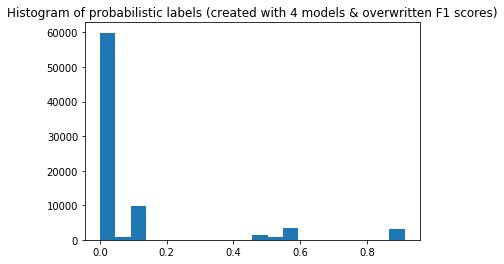

In [134]:
plt.hist(train_marginals_F1, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & overwritten F1 scores)'%n_models)
plt.show()

In [254]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.940637
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.910915
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.922221
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.918230


Text(0.5,1,'Unweighted voting for 12 classifiers')

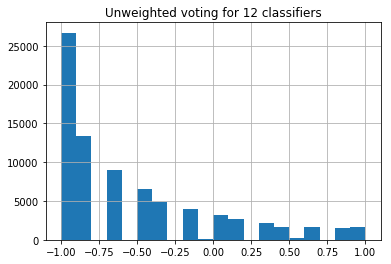

In [91]:
#this would be with unweighted voting

pd.Series(list(map(lambda x:x[0].item(),L_unlab.mean(axis=1)))).hist(bins=20)
plt.title('Unweighted voting for 12 classifiers')

In [132]:
from MLutils import majority_vote_score, majority_vote

In [137]:
majority_vote_score(L_dev, L_gold_dev)

pos/neg    705:2525 21.8%/78.2%
precision  67.84
recall     54.75
f1         60.60


In [ ]:
logp_false = e^10
logp_true = e

In [ ]:
1 / (1 + np.exp(logp_false - logp_true))

In [154]:
gen_model.weights.dep_similar

<4x4 sparse matrix of type '<type 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

## save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on

In [68]:
from snorkel.annotations import save_marginals
save_marginals(session, L_unlab, unlab_marginals)

Saved 79400 marginals


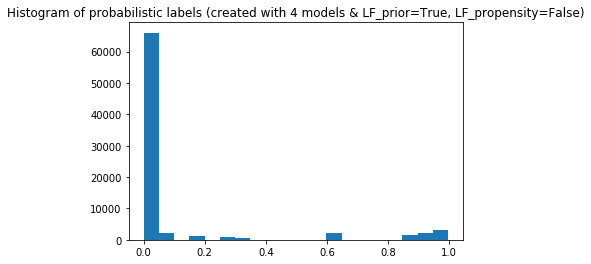

In [93]:
plt.hist(train_marginals, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

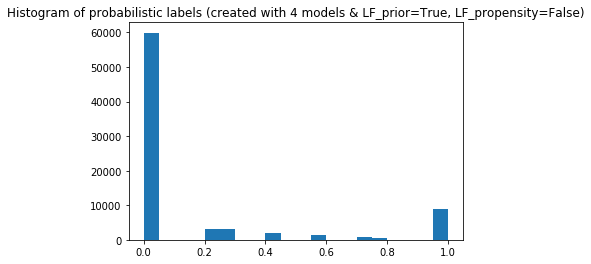

In [92]:
plt.hist(train_marginals_w_prior, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

# ~~ 

In [47]:
L_test = labeler.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%



In [49]:
# load from db gold labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<13350x1 sparse matrix of type '<type 'numpy.int64'>'
	with 5781 stored elements in Compressed Sparse Row format>

In [50]:
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.975
Precision            0.57
Recall               0.259
F1                   0.356
----------------------------------------
TP: 388 | FP: 293 | TN: 11557 | FN: 1112



In [51]:
L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
dummy,0,1.000000,0.433034,0.128764,0,0,1500,4281,0.740529,0.936173
LogisticRegression,1,0.433034,0.433034,0.128764,683,563,817,3718,0.761287,0.893057
SVC_linear,2,0.433034,0.433034,0.128764,594,592,906,3689,0.740875,0.888321
SVC_rbf_C100,3,0.433034,0.433034,0.128764,606,500,894,3781,0.758865,0.893826
SVC_rbf_C500,4,0.433034,0.433034,0.128764,625,484,875,3797,0.764920,0.897841
SVC_rbf_C1000,5,0.433034,0.433034,0.128764,577,480,923,3801,0.757308,0.899282
